# **<center> <span style="color: pink;">ATML PA_0 </span>**

### <span style="color: DeepPink;"> Name : Khadeeja Toseef </span>
### <span style="color: DeepPink;"> Roll Number : 27100309 </span>

## <center> <span style="color: pink;">Task 5: Modality Gap in CLIP </span>

### <span style="color: HotPink;"> 1. Zero-Shot Classification on STL-10
</span>

<span style="color: MediumPurple;"> (a) Download the STL-10 dataset from torchvision.
</span>

<span style="color: #D8BFD8;">importing libraries </span>

In [1]:
# !pip install clip
!pip uninstall -y clip
!pip install git+https://github.com/openai/CLIP.git
import os
import umap
import clip
import torch
import torchvision

import numpy as np
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
from torchvision.datasets import STL10
from tqdm import tqdm
# from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-7ciw9zed
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-7ciw9zed
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=42b5d6e59611307b3008c6467a9c5fbb237c1ad70e3e564b4116e3b299c08489
  Stored in directory: /tmp/pip-ephem-wheel-cache-zp5c7qiz/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


In [2]:
print(dir(clip))

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'available_models', 'clip', 'load', 'model', 'simple_tokenizer', 'tokenize']


In [3]:

# Load CLIP preprocessing pipeline
_, preprocess = clip.load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")

trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=preprocess)
testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=preprocess)

dataloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

print("STL-10 dataset downloaded.")

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 68.2MiB/s]
100%|██████████| 2.64G/2.64G [02:49<00:00, 15.6MB/s]


STL-10 dataset downloaded.


<span style="color: MediumPurple;"> (b) Load OpenAI’s CLIP model from the official implementation of clip.
</span>

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [5]:
classnames = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

<span style="color: MediumPurple;"> (c) Evaluate clip for zero-shot accuracy on STL-10 using different prompting techniques:
</span>   

<span style="color: MediumPurple;"> i. Plain labels (e.g., “cat”).
</span>  

In [6]:
plain_text_prompts = classnames

# tokenize prompts
text_inputs = torch.cat([clip.tokenize(label) for label in plain_text_prompts]).to(device)

# encode prompted text features
with torch.no_grad():
    text_features = model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)  # normalize

# evaluate zero-shot classification with prompted text
correct = 0
total = 0

print("\nEvaluating Zero-Shot Accuracy on STL-10 (Plain Prompts)...")

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # encode image features
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # compute similarity (cosine) between image and text features
        similarity = (100.0 * image_features @ text_features.T)  # shape: [batch_size, num_classes]
        predictions = similarity.argmax(dim=1)

        correct += (predictions == labels).sum().item()
        total += labels.size(0)

# Final accuracy
accuracy = 100 * correct / total
print(f"\nZero-Shot Accuracy with Plain Labels: {accuracy:.2f}%")



Evaluating Zero-Shot Accuracy on STL-10 (Plain Prompts)...


100%|██████████| 125/125 [00:20<00:00,  6.19it/s]


Zero-Shot Accuracy with Plain Labels: 96.26%


<span style="color: MediumPurple;"> ii. Prompted text (e.g., “a photo of a cat”).
</span>   

In [7]:
prompted_text_prompts = [f"a photo of a {label}" for label in classnames]

# tokenize prompts
text_inputs_prompted = torch.cat([clip.tokenize(p) for p in prompted_text_prompts]).to(device)

# encode prompted text features
with torch.no_grad():
    text_features_prompted = model.encode_text(text_inputs_prompted)
    text_features_prompted /= text_features_prompted.norm(dim=-1, keepdim=True)

# evaluate zero-shot classification with prompted text
correct_prompted = 0
total_prompted = 0

print("\nEvaluating Zero-Shot Accuracy on STL-10 (Prompted Text: 'a photo of a <label>')...")

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features_prompted.T)
        predictions = similarity.argmax(dim=1)

        correct_prompted += (predictions == labels).sum().item()
        total_prompted += labels.size(0)

accuracy_prompted = 100 * correct_prompted / total_prompted
print(f"\nZero-Shot Accuracy with Prompted Text ('a photo of a <label>'): {accuracy_prompted:.2f}%")



Evaluating Zero-Shot Accuracy on STL-10 (Prompted Text: 'a photo of a <label>')...


100%|██████████| 125/125 [00:19<00:00,  6.55it/s]


Zero-Shot Accuracy with Prompted Text ('a photo of a <label>'): 97.36%


<span style="color: MediumPurple;"> iii. More descriptive variants of prompts.
</span>

In [8]:
# ----------- (iii) More Descriptive Prompts -----------
descriptive_prompts = [f"a high-resolution photo of a cute {label} in nature" for label in classnames]

# Tokenize descriptive prompts
text_inputs_desc = torch.cat([clip.tokenize(p) for p in descriptive_prompts]).to(device)

# Encode text features for descriptive prompts
with torch.no_grad():
    text_features_desc = model.encode_text(text_inputs_desc)
    text_features_desc /= text_features_desc.norm(dim=-1, keepdim=True)

# Evaluate with descriptive prompts
correct_desc = 0
total_desc = 0

print("\nEvaluating Zero-Shot Accuracy on STL-10 (Descriptive Prompts)...")

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        similarity = (100.0 * image_features @ text_features_desc.T)
        predictions = similarity.argmax(dim=1)

        correct_desc += (predictions == labels).sum().item()
        total_desc += labels.size(0)

accuracy_desc = 100 * correct_desc / total_desc
print(f"\nZero-Shot Accuracy with Descriptive Prompts: {accuracy_desc:.2f}%")



Evaluating Zero-Shot Accuracy on STL-10 (Descriptive Prompts)...


100%|██████████| 125/125 [00:17<00:00,  6.98it/s]


Zero-Shot Accuracy with Descriptive Prompts: 96.25%


<span style="color: MediumPurple;"> (d) You can experiment with the prompts on a small subset. However, you are to compare accuracies across atleast 3 different prompting strategies for the whole test set
</span>

In [9]:
print("\n==== Zero-Shot Accuracy Comparison on STL-10 ====")
print(f"Plain labels           : {accuracy:.2f}%")
print(f"Prompted ('a photo of'): {accuracy_prompted:.2f}%")
print(f"Descriptive prompts    : {accuracy_desc:.2f}%")


==== Zero-Shot Accuracy Comparison on STL-10 ====
Plain labels           : 96.26%
Prompted ('a photo of'): 97.36%
Descriptive prompts    : 96.25%


### <span style="color: HotPink;"> 2. Exploring the Modality Gap
</span>

<span style="color: MediumPurple;"> (a) Use the vision and text model within CLIP to extract image and label embeddings from CLIP for a few (50-100) STL-10 samples.
</span>

In [10]:
# Extract image and text embeddings for a subset of STL-10 samples

num_samples = 100  # Number of samples to use
subset_indices = np.random.choice(len(testset), num_samples, replace=False)
subset_testset = torch.utils.data.Subset(testset, subset_indices)
subset_dataloader = DataLoader(subset_testset, batch_size=32, shuffle=False, num_workers=2)

image_embeddings = []
labels_list = []

print(f"\nExtracting image embeddings for {num_samples} samples...")
with torch.no_grad():
    for images, labels in tqdm(subset_dataloader):
        images = images.to(device)
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_embeddings.append(image_features.cpu())
        labels_list.append(labels.cpu())

image_embeddings = torch.cat(image_embeddings)
labels_list = torch.cat(labels_list)

# Extract text embeddings for class names
text_inputs = torch.cat([clip.tokenize(label) for label in classnames]).to(device)
with torch.no_grad():
    text_embeddings = model.encode_text(text_inputs)
    text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

print("Image and text embeddings extracted.")


Extracting image embeddings for 100 samples...


100%|██████████| 4/4 [00:00<00:00,  8.85it/s]

Image and text embeddings extracted.


<span style="color: MediumPurple;"> (b) Use dimensionality reduction techniques such as UMAP or t-SNE to project the embeddings into 2D space.
</span>

In [11]:
# Concatenate image and text embeddings for dimensionality reduction
all_embeddings = torch.cat([image_embeddings, text_embeddings.cpu()]) # Move text_embeddings to CPU
all_labels = torch.cat([labels_list, torch.arange(len(classnames)) + len(torch.unique(labels_list))]) # Assign unique labels to text embeddings

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = reducer.fit_transform(all_embeddings)

# Separate reduced embeddings
reduced_image_embeddings = reduced_embeddings[:len(image_embeddings)]
reduced_text_embeddings = reduced_embeddings[len(image_embeddings):]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


<span style="color: MediumPurple;"> (c) Visualize and compare the distributions of text and image embeddings.
</span>

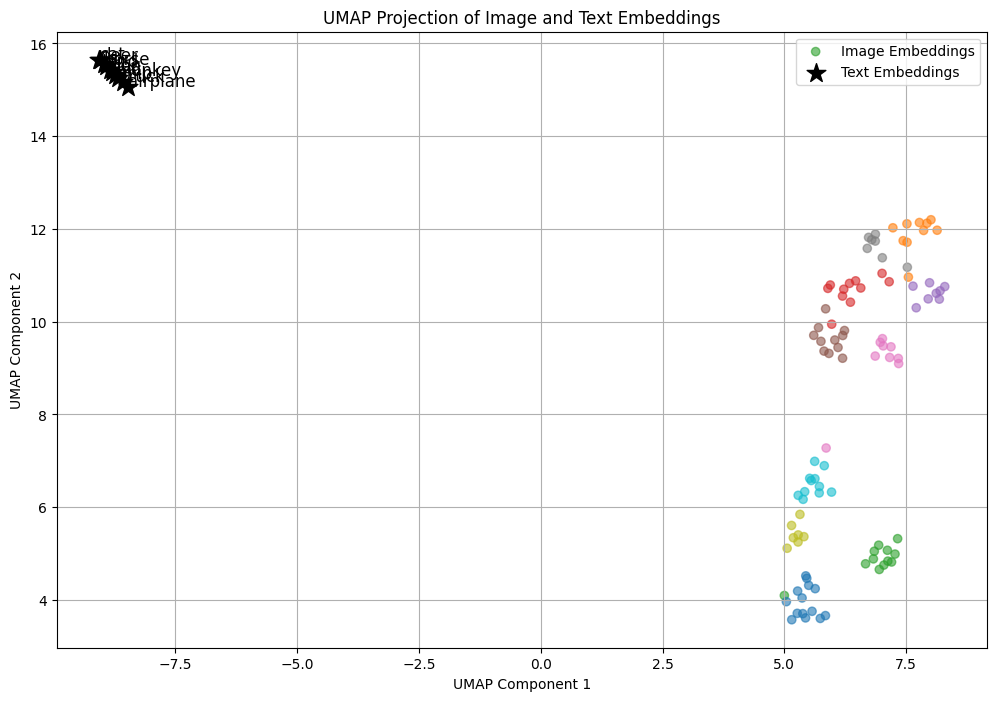

In [12]:
# Visualize the reduced embeddings
plt.figure(figsize=(12, 8))

# Plot image embeddings, colored by their class
scatter_image = plt.scatter(reduced_image_embeddings[:, 0], reduced_image_embeddings[:, 1],
                            c=labels_list, cmap='tab10', label='Image Embeddings', alpha=0.6)

# Plot text embeddings with distinct markers
scatter_text = plt.scatter(reduced_text_embeddings[:, 0], reduced_text_embeddings[:, 1],
                           marker='*', s=200, color='black', label='Text Embeddings')

# Add class names next to text embeddings
for i, label in enumerate(classnames):
    plt.text(reduced_text_embeddings[i, 0], reduced_text_embeddings[i, 1], label, fontsize=12)

plt.title('UMAP Projection of Image and Text Embeddings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.grid(True)
plt.show()

<span style="color: MediumPurple;"> (d) Briefly explain your findings:
</span>

### <span style="color:DarkCyan;"> How separated are the modalities? Does normalization affect the modality gap? Why does CLIP still perform well despite this gap?
</span>

ANSWER = <span style="color: #D8BFD8;"> The UMAP projection highlights a clear separation between image and text embeddings, with text representations forming a compact cluster and image representations distributed into distinct groups. This separation reflects the presence of a modality gap, wherein embeddings from different modalities occupy different regions of the reduced space. However, this gap is partly an artifact of dimensionality reduction and the lack of normalization. When embeddings are L2-normalized, as is standard in CLIP, both modalities are projected onto the same hypersphere, effectively reducing this gap in the similarity space. CLIP remains effective despite the apparent separation because its training objective explicitly optimizes for paired image–text alignment using cosine similarity. As a result, even if UMAP suggests divergence in raw coordinates, the embeddings of semantically matched images and texts are still well aligned in the high-dimensional normalized space, enabling strong zero-shot and cross-modal retrieval performance.
</span>

### <span style="color: HotPink;"> 3. Bridging the Modality Gap
</span>

<span style="color: MediumPurple;"> (a) One simple method to align modalities is the orthogonal Procrustes transform.
Given two sets of embeddings $X$ (image features) and $Y$ (text features),
the goal is to find an orthogonal matrix $R$ that minimizes:</span>
$$
\color{MediumPurple}{\min_{R} \; \| XR - Y \|_{F},}
$$
<span style="color: MediumPurple;">
where
</span>

$\| \cdot \|_{F}$

<span style="color: MediumPurple;">
is the Frobenius norm.
</span>
<span style="color: MediumPurple;">
The closed-form solution involves singular value decomposition (SVD),
but a library implementation will suffice for our case.
</span>

In [13]:
from scipy.linalg import orthogonal_procrustes

<span style="color: MediumPurple;"> (b) Pair STL-10 image embeddings with their corresponding text embeddings.
</span>

In [14]:
# text embeddings corresponding to each image label
paired_text_embeddings = text_embeddings[labels_list]

<span style="color: MediumPurple;"> (c) Learn the optimal rotation matrix R using a library implementation of Procrustes alignment (hint: scipy.linalg.orthogonal procrustes or equivalent).
</span>

In [15]:
R, _ = orthogonal_procrustes(image_embeddings.cpu().numpy(), paired_text_embeddings.cpu().numpy())

<span style="color: MediumPurple;"> (d) Apply the rotation transform to the CLIP embeddings.
</span>

In [16]:
aligned_image_embeddings = torch.tensor(image_embeddings.numpy() @ R).float()

<span style="color: MediumPurple;"> (e) Visualize the aligned embeddings with t-SNE or UMAP. How does the alignment affect the modality
gap?
</span>

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


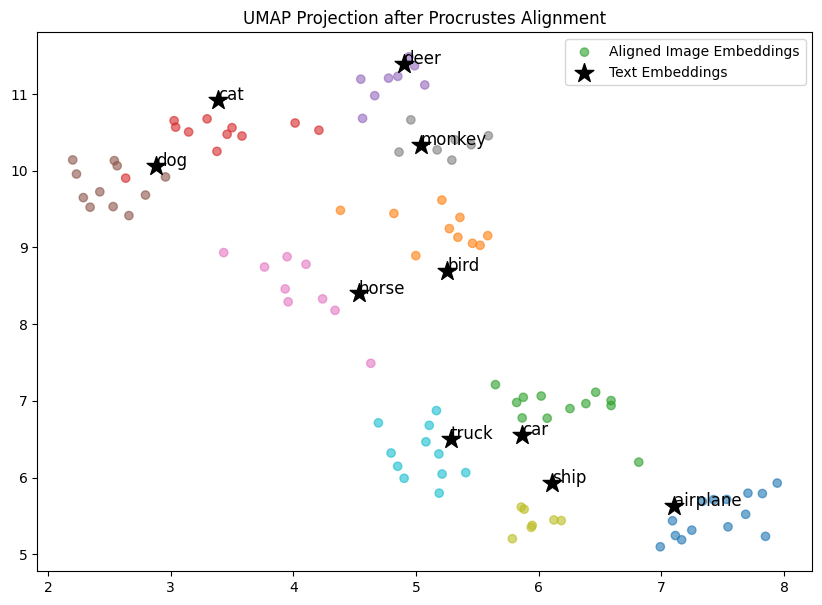

In [17]:
all_aligned = torch.cat([aligned_image_embeddings, text_embeddings.cpu()])

reduced_aligned = umap.UMAP(n_components=2, random_state=42).fit_transform(all_aligned)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_aligned[:len(aligned_image_embeddings), 0], reduced_aligned[:len(aligned_image_embeddings), 1],
            c=labels_list, cmap='tab10', alpha=0.6, label='Aligned Image Embeddings')
plt.scatter(reduced_aligned[len(aligned_image_embeddings):, 0], reduced_aligned[len(aligned_image_embeddings):, 1],
            marker='*', s=200, color='black', label='Text Embeddings')

for i, label in enumerate(classnames):
    plt.text(reduced_aligned[len(aligned_image_embeddings)+i, 0],
             reduced_aligned[len(aligned_image_embeddings)+i, 1], label, fontsize=12)

plt.title('UMAP Projection after Procrustes Alignment')
plt.legend()
plt.show()


<span style="color: MediumPurple;"> (f) Recompute classification accuracy with the aligned embeddings and compare results with Part 0.
</span>

In [18]:
# Normalize text and aligned image embeddings
aligned_image_embeddings /= aligned_image_embeddings.norm(dim=-1, keepdim=True)
text_features_norm = text_features / text_features.norm(dim=-1, keepdim=True)  # from part 1
text_features_norm = text_features_norm.to(dtype=torch.float32)

correct_aligned = 0
total_aligned = 0

with torch.no_grad():
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # encode images
        img_feats = model.encode_image(images)
        img_feats /= img_feats.norm(dim=-1, keepdim=True)

        # Apply rotation
        img_feats_rotated = torch.tensor(img_feats.cpu().numpy() @ R).to(device)
        img_feats_rotated /= img_feats_rotated.norm(dim=-1, keepdim=True)
        img_feats_rotated = img_feats_rotated.to(dtype=text_features_norm.dtype)

        print(img_feats_rotated.dtype, text_features_norm.dtype)

        # similarity and predictions
        similarity = (100.0 * img_feats_rotated @ text_features_norm.T)
        preds = similarity.argmax(dim=1)

        correct_aligned += (preds == labels).sum().item()
        total_aligned += labels.size(0)

accuracy_aligned = 100 * correct_aligned / total_aligned
print(f"Zero-Shot Accuracy with Aligned Embeddings: {accuracy_aligned:.2f}%")


  1%|          | 1/125 [00:00<01:49,  1.14it/s]

torch.float32 torch.float32


  2%|▏         | 2/125 [00:01<00:57,  2.14it/s]

torch.float32 torch.float32


  3%|▎         | 4/125 [00:01<00:36,  3.35it/s]

torch.float32 torch.float32
torch.float32 torch.float32


  5%|▍         | 6/125 [00:02<00:31,  3.72it/s]

torch.float32 torch.float32
torch.float32 torch.float32


  6%|▋         | 8/125 [00:02<00:24,  4.75it/s]

torch.float32 torch.float32
torch.float32 torch.float32


  7%|▋         | 9/125 [00:02<00:25,  4.49it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 10%|▉         | 12/125 [00:03<00:19,  5.79it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 11%|█         | 14/125 [00:03<00:17,  6.18it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 13%|█▎        | 16/125 [00:03<00:18,  5.96it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 14%|█▍        | 18/125 [00:04<00:18,  5.65it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 16%|█▌        | 20/125 [00:04<00:17,  6.09it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 18%|█▊        | 22/125 [00:04<00:17,  5.99it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 18%|█▊        | 23/125 [00:05<00:18,  5.42it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 20%|██        | 25/125 [00:05<00:18,  5.53it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 22%|██▏       | 28/125 [00:05<00:15,  6.24it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 24%|██▍       | 30/125 [00:06<00:16,  5.83it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 26%|██▌       | 32/125 [00:06<00:14,  6.28it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 26%|██▋       | 33/125 [00:06<00:16,  5.71it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 29%|██▉       | 36/125 [00:07<00:13,  6.41it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 30%|██▉       | 37/125 [00:07<00:14,  5.89it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 32%|███▏      | 40/125 [00:07<00:12,  6.63it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 33%|███▎      | 41/125 [00:08<00:14,  5.88it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 35%|███▌      | 44/125 [00:08<00:12,  6.30it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 37%|███▋      | 46/125 [00:08<00:13,  5.81it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 38%|███▊      | 48/125 [00:09<00:13,  5.91it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 40%|████      | 50/125 [00:09<00:13,  5.77it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 42%|████▏     | 52/125 [00:10<00:13,  5.57it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 42%|████▏     | 53/125 [00:10<00:14,  5.03it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 44%|████▍     | 55/125 [00:10<00:13,  5.24it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 46%|████▌     | 57/125 [00:10<00:11,  5.91it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 47%|████▋     | 59/125 [00:11<00:10,  6.02it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 50%|████▉     | 62/125 [00:11<00:10,  6.11it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 51%|█████     | 64/125 [00:12<00:11,  5.46it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 53%|█████▎    | 66/125 [00:12<00:11,  4.99it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 54%|█████▍    | 68/125 [00:13<00:13,  4.38it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 56%|█████▌    | 70/125 [00:13<00:13,  3.97it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 58%|█████▊    | 72/125 [00:14<00:12,  4.24it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 58%|█████▊    | 73/125 [00:14<00:14,  3.48it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 61%|██████    | 76/125 [00:15<00:10,  4.57it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 62%|██████▏   | 78/125 [00:15<00:08,  5.36it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 64%|██████▍   | 80/125 [00:15<00:07,  5.79it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 65%|██████▍   | 81/125 [00:16<00:07,  5.64it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 67%|██████▋   | 84/125 [00:16<00:06,  6.10it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 69%|██████▉   | 86/125 [00:16<00:06,  5.85it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 70%|███████   | 88/125 [00:17<00:05,  6.38it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 72%|███████▏  | 90/125 [00:17<00:05,  6.15it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 73%|███████▎  | 91/125 [00:17<00:05,  5.67it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 74%|███████▍  | 93/125 [00:18<00:05,  5.77it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 76%|███████▌  | 95/125 [00:18<00:05,  5.62it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 78%|███████▊  | 97/125 [00:18<00:04,  5.99it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 79%|███████▉  | 99/125 [00:19<00:04,  5.71it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 82%|████████▏ | 102/125 [00:19<00:03,  6.14it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 82%|████████▏ | 103/125 [00:19<00:03,  5.79it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 84%|████████▍ | 105/125 [00:20<00:03,  6.07it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 86%|████████▋ | 108/125 [00:20<00:02,  6.34it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 87%|████████▋ | 109/125 [00:20<00:02,  5.90it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 89%|████████▉ | 111/125 [00:21<00:02,  6.05it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 91%|█████████ | 114/125 [00:21<00:01,  6.05it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 93%|█████████▎| 116/125 [00:22<00:01,  6.16it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 94%|█████████▍| 118/125 [00:22<00:01,  6.57it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 96%|█████████▌| 120/125 [00:22<00:00,  6.08it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 98%|█████████▊| 122/125 [00:22<00:00,  6.32it/s]

torch.float32 torch.float32
torch.float32 torch.float32


 98%|█████████▊| 123/125 [00:23<00:00,  5.57it/s]

torch.float32 torch.float32
torch.float32 torch.float32


100%|██████████| 125/125 [00:23<00:00,  5.30it/s]

torch.float32 torch.float32
Zero-Shot Accuracy with Aligned Embeddings: 95.11%
